In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
#from numba import jit
%matplotlib inline

Pi = np.pi

The first example of a fractal we will run into is the Weierstrass function which is given by
$$
f(x;a,b) = \sum_{k=0}^{\infty} a^{k}\cos(b^{k}\pi x), ~ 0<a<1, ~ ab > 1 + \frac{3\pi}{2}
$$

In [2]:
def wfunc(x,a,b,tol):
    xp = x*Pi
    tot = np.cos(xp)
    term = 1.
    aval = 1.
    bval = 1.
    while(abs(term)>=tol):
        aval *= a
        bval *= b
        term = aval*np.cos(bval*xp)
        tot += term
    return tot

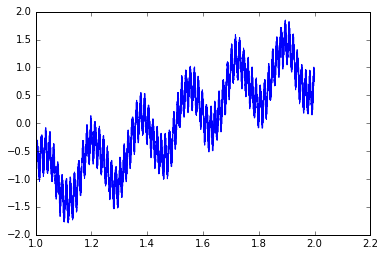

In [3]:
xvals = np.linspace(1,2,1e4)
a,b = .5, (2+3*Pi+.2)
yvals = [wfunc(xval,a,b,1e-12) for xval in xvals]
plt.plot(xvals,yvals)

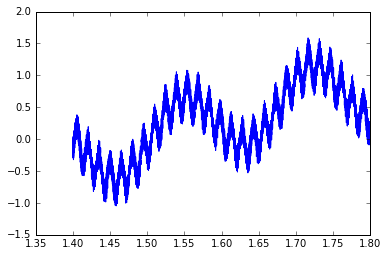

In [4]:
xvals = np.linspace(1.4,1.8,1e4)
a,b = .5, (2+3*Pi+.2)
yvals = [wfunc(xval,a,b,1e-12) for xval in xvals]
plt.plot(xvals,yvals)

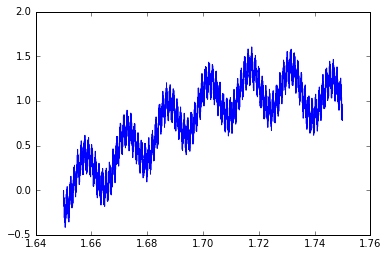

In [5]:
xvals = np.linspace(1.65,1.75,1e4)
a,b = .5, (2+3*Pi+.2)
yvals = [wfunc(xval,a,b,1e-12) for xval in xvals]
plt.plot(xvals,yvals)

*The Koch Curve* : While the Weirstrass example above helps us get a quick idea of fractal behavior, a better example is found by building the Koch Curve.  This starts from drawing a line segment, say between the initial points ${\bf P}=(0,0)$ and ${\bf Q}=(1,0)$.  Note in Python, to encode these points, we want to use Numpy arrays so that 

`P = np.array([0.,0.])`

`Q = np.array([1.,0.])`

The idea now is to remove the middle third of the line segment between ${\bf P}$ and ${\bf Q}$ and in its place draw an equilateral triangle which introduces the points ${\bf A}$, ${\bf B}$, and ${\bf C}$.  See the figure below. 

<img src="koch_curve.png" alt="Drawing" style="width: 200px;"/>

In [6]:
def k_plot(P,Q,ptsx,ptsy,nlev):
    if nlev > 0:
        
        # Compute the new points A, B, and C from the endpoints of the line segment P and Q
        
        d = Q - P
        dperp = np.array([-d[1],d[0]])
        A = P + d/3.
        B = (P+Q)/2. + dperp/(2.*np.sqrt(3))
        C = P + 2.*d/3.
        
        # Determine the index associated with Q in ptsx and ptsy.
        
        ind = 0
        
        indsx = [ii for ii,x in enumerate(ptsx) if x==Q[0]]
        indsy = [jj for jj,y in enumerate(ptsy) if y==Q[1]]
        
        for indy in indsy:
            for indx in indsx:
                if indy == indx: 
                    ind = indx
                    break
        
        # Insert C, B, and A in the correct order relative to the index 'ind' associated with the point
        # Q.
        
        ptsx.insert(ind,C[0])
        ptsx.insert(ind,B[0])
        ptsx.insert(ind,A[0])
        
        ptsy.insert(ind,C[1])
        ptsy.insert(ind,B[1])
        ptsy.insert(ind,A[1])
        
        # Recurse down to the next level and repeat the process over again.
        
        k_plot(P,A,ptsx,ptsy,nlev-1) # Repeat process between P and A
        k_plot(A,B,ptsx,ptsy,nlev-1) # Repeat process between A and B
        k_plot(B,C,ptsx,ptsy,nlev-1) # Repeat process between B and C
        k_plot(C,Q,ptsx,ptsy,nlev-1) # Repeat process between C and Q   

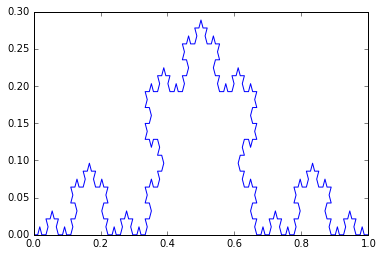

In [8]:
P = np.array([0.,0.])
Q = np.array([1.,0.])
ptsx = [0.,1.] # Initialize ptsx with the x-coordinates of P and Q
ptsy = [0.,0.] # Initialize ptsy with the y-coordinates of P and Q
k_plot(P,Q,ptsx,ptsy,4)
plt.plot(ptsx,ptsy)

*The Sierpinski Triangle*  So this is in some ways almost more straightforward than the Koch curve.  Start with an equilateral triangle.  Label its vertices as $A$, $B$, and $C$.  Between the midpoints of the vertices, draw another triangle.  Repeat this process on the three, smaller surounding triangles introduced by drawing the second, interior triangle.  

In [14]:
def sierp(A,B,C,n):
    
    if n>=1:
    
        plt.plot([A[0],B[0]],[A[1],B[1]],color='k')
        plt.plot([B[0],C[0]],[B[1],C[1]],color='k')
        plt.plot([C[0],A[0]],[C[1],A[1]],color='k')
        
        AB = (A+B)/2.
        BC = (B+C)/2.
        AC = (A+C)/2.
         
        sierp(A,AB,AC,n-1)
        sierp(AB,B,BC,n-1)
        sierp(AC,BC,C,n-1)

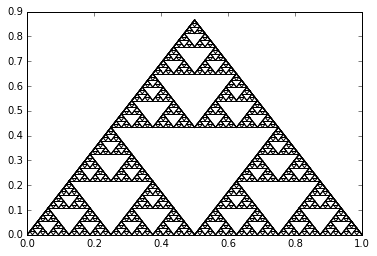

In [15]:
A = np.array([.5,np.sqrt(3)/2])
B = np.array([0.,0.])
C = np.array([1.,0.])
sierp(A,B,C,7)


*The Mandelbrot Set* First, let's talk about the complex plane $\mathbb{C}$, by which we mean the set of points $z$ where

$$
z = x + iy, ~ i=\sqrt{-1}
$$

and $x$ and $y$ are real.  See the following figure for reference.

![title](complex_plane.gif)

We can talk about the magnitude of a complex number $|z|$ where we define this to be

$$
|z| = (z_{r}^{2}+z_{i}^{2})^{1/2}
$$

Don't let the notation push you around.  This is just Pythagoras theorem, or vector length in the plane and nothing more.  

Once we have these definitions in place, things more or less work the same way as you are used to on the real line, though you have to do more work usually.  For example, we have that 

$$
z^{2} = (x+iy)^{2} = x^{2}+2ixy+i^2y^2 = x^{2}-y^{2} + 2ixy
$$

We can therefore readily see that the map $f(z) = z^{2}$ maps the complex plane into the complex plane i.e.

$$
f : \mathbb{C} \rightarrow \mathbb{C}.
$$

We can then talk about families of maps such as

$$
f_{c}(z) = z^{2} + c,~ c = c_{r} + ic_{i}
$$

and to tie it in with everything we have been talking about, we can now look at complex discrete dynamical systems of the form 

$$
z_{n+1} = f_{c}(z_{n}), 
$$

So, we can now start asking some funny sorts of questions.  For example, what values of $c$ will make the sequence starting from $z_{0}=0$ remain bounded, i.e. can we describe the set

$$
M_{0} = \left\{c\in\mathbb{C} : \left|f_{c}(z_{n})\right|\leq M, ~ n>0,~z_{0}=0\right\}
$$

This is not a trivial question.  Let's see why.  If $z_{0}=0$, we then have 

$$
z_{1} = c, ~ z_{2} = c^{2} + c, ~ z_{3} = (c^{2}+c)^{2} + c, \cdots
$$

So sure, you could figure out a pattern, but it is going to be a mess.  As we will shortly see, while not necessarily hot, it is a beautiful mess indeed.  

So the way we will study this question is to do the following.  Given $c$ and $z_{0}=0$, we generate a sequence of points $z_{n}$ in the complex plane.  What we are looking at is plotting the value $n$ such that 

$$
\left|z_{n}\right| > M,
$$

or at what iterate, $n(c)$, do we leave the complex disc centered at the origin of radius $M$?  Note, I write $n(c)$ to emphasize that as we *change* $c$, the number of iterations it takes to have $|z_{n}| > M$ depends on $c$.  

In [12]:
def fmap(z,c):
    return z**2 + c

def M_set(Xmin,Xmax,Ymin,Ymax,M,Niter,Nvals):
    
    # Xmin - Lower bound of real axis we take values of c from
    # Xmax - Upper bound of real axis we take values of c from
    # Ymin - Lower bound of imaginary axis we take values of c from
    # Ymax - Upper bound of imaginary axis we take values of c from
    # M - Radius of the complex disc which defines our bounded region
    # Niter - Maximum number of iterations
    # Nvals - Number of points along the real and imaginary axis we use to study different values of c
    
    Xaxis = np.linspace(Xmin,Xmax,Nvals)
    Yaxis = np.linspace(Ymin,Ymax,Nvals)
    
    iter_cnt = np.zeros([Nvals,Nvals])
    
    for jj in range(Nvals):
        for kk in range(Nvals):
            cval = Xaxis[jj] + 1j*Yaxis[kk] # We try many different cvals
            zval = cval # We always start from z_1 = c since z_0 = 0.
            n = 0 # We always initialize the count of our iterations to be 0
           
            while n < Niter: # We iterate until we hit the maximum number of iterations
                zval = fmap(zval,cval) # Apply the map to generate the next point in the sequence.  
                n += 1 # If we haven't stopped yet, update the iteration count.
                if(np.abs(zval)>M): break # If we are outside the disc of radius M, we stop.
                
            iter_cnt[jj,kk] = n # Store the iteration count
            
    # This is a bunch of plotting stuff.  If you don't learn it, that is fine.              
    dpi = 72
    width = 10
    height = 10
    img_width = dpi * width
    img_height = dpi * height
    
    fig, ax = plt.subplots(figsize=(width, height),dpi=72)
    ticks = np.arange(0,img_width,3*dpi)
    x_ticks = Xmin + (Xmax-Xmin)*ticks/img_width
    plt.xticks(ticks, x_ticks)
    y_ticks = Ymin + (Ymax-Ymin)*ticks/img_width
    plt.yticks(ticks, y_ticks)
    
    ax.imshow(iter_cnt.T,origin='lower') 

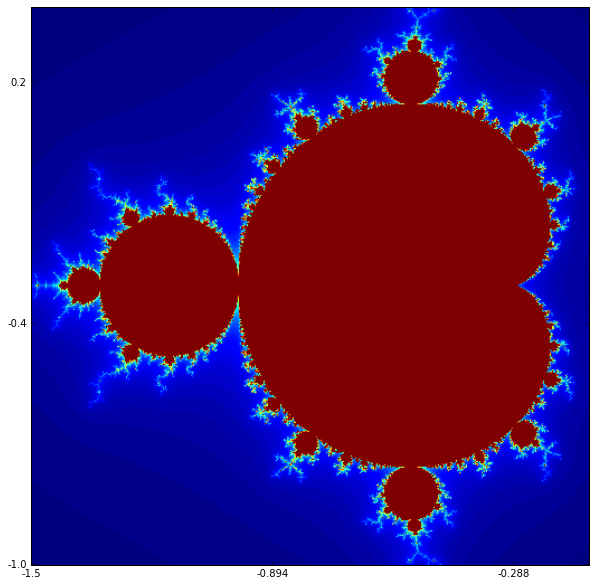

In [16]:
M_set(-1.5,.52,-1.,1.,1e2,1e2,500)